In [1]:
%matplotlib inline

# Objective

The goal of this section of the project is to extract quantitative features from the traffic cameras.

We will attempt to obtain the following features from the captured images:
* Object count: We will obtain object count after applying various thresholding schemes.
* Standard deviation of the value of the pixels

# Image Processing and Feature Extraction

As proposed in the [data collection section](https://github.com/rmalarc/is602/blob/master/final_project/nyc_traffic_data_aggregator.ipynb), we collected still frames of the trafic cameras located at these locations:

* Van Wyck Expwy @ 87 Ave: http://nyctmc.org/google_popup.php?cid=590
* Van Wyck Expwy @ Hillside Ave: http://nyctmc.org/google_popup.php?cid=587
* Van Wyck Expwy @ 91 Ave: http://nyctmc.org/google_popup.php?cid=586
* Van Wyck Expwy @ 101 Ave SB: http://nyctmc.org/google_popup.php?cid=584
* Van Wyck Expwy @ 101 Ave NB: http://nyctmc.org/google_popup.php?cid=582

Let's look at a sample of the captured images:


<table><tr>
<td>VWE @ 101 Ave NB<img src="https://raw.githubusercontent.com/rmalarc/is602/master/final_project/camera_data/1447258654_cctv589.jpg"></td>
<td>VWE @ 101 Ave SB<img src="https://raw.githubusercontent.com/rmalarc/is602/master/final_project/camera_data/1447328896_cctv590.jpg"></td>
<td>VWE @ 91 Ave<img src="https://raw.githubusercontent.com/rmalarc/is602/master/final_project/camera_data/1447328896_cctv592.jpg"></td></tr><tr>
<td>VWE @ Hillside Ave<img src="https://raw.githubusercontent.com/rmalarc/is602/master/final_project/camera_data/1447328896_cctv593.jpg"></td>
<td>VWE @ 87 Ave<img src="https://raw.githubusercontent.com/rmalarc/is602/master/final_project/camera_data/1447258654_cctv594.jpg"></td>
<td></td></tr></table>

As we can see from the pictures above, all the cameras have a distinct vantage point of the road. The vantage point changes both the perspective and the real/apparent size of the vehicles on the road. In order to compensate for those we will:

* Identify a fixed-area sample within each image: Fortunately, we can rely on the number of [road stripes](http://researchnews.osu.edu/archive/seeline.htm) and [number of lanes](http://safety.fhwa.dot.gov/geometric/pubs/mitigationstrategies/chapter3/3_lanewidth.cfm) as a visual cue to obtain a fixed-area sample of the road . We will crop the images in order to obtain a sample the traffic over a 3-lane by 2-dash segment of the road (roughly 36'x80' area)
* Warp the sample area: The goal with this step is to undo the angular skew of the images. We will attempt to obtain a flat image as if the camera was positioned at a 90 degree angle relative to the road. Fortunatelly, skimage has good support for doing geometric transformations (http://scikit-image.org/docs/dev/auto_examples/applications/plot_geometric.html#example-applications-plot-geometric-py)

From the fixed-area sample we will obtain the following features for the analysis:

* Object Count
* Standard Deviation

In the next episode, we will attempt to model the observed car count in the road segment as a function of the object count or the standard deviation of the pixels in the image. The best model will win.



## The Code

In [2]:
from __future__ import print_function

import math
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas

#import scipy.ndimage as ndimage

from skimage.measure import label
from skimage import io
from skimage import transform as tf

from skimage.restoration import denoise_bilateral

In order to get the job done, let's define a couple of helper classes that will make our life easier:

* ImageIO: We'll use this class to define basic image i/o functionality, such as read, write and plotting.
* ImageTransform: This class inherits ImageIO and adds the transformation functionality that we want to achieve in the project.

In [3]:
class ImageIO:
    def __init__(self):
        self.image = []
        self.image = np.ndarray(self.image)
        pass

    def load_image(self,filename):
        self.image = io.imread(filename,as_grey =True)

    def save_image(self,filename):
        io.imsave(filename,self.image)

    def plot(self):
        fig, ax1 = plt.subplots()
        ax1.imshow(self.image, cmap=plt.cm.gray)
        ax1.axis('off')
        plt.show()

class ImageProcessing(ImageIO):

    def denoise(self,sigma_range=0.05,sigma_spatial=15):
        self.image = denoise_bilateral(self.image
                                       , sigma_range=sigma_range
                                       , sigma_spatial=sigma_spatial)

    def threshold(self,threshold):
        self.image = (self.image > threshold)

#    def object_count(self):
#        return ndimage.label(self.image)[1]

    def object_count(self):
        return label(self.image).max()+1

    def warp(self, warp,width=160,height=80):
        src = np.array((
            (width, 0),
            (0, 0),
            (width, height),
            (0, height)
        ))

        tform3 = tf.ProjectiveTransform()
        tform3.estimate(src, warp)
        self.image = tf.warp(self.image, tform3, output_shape=(height, width))


Let's try it:

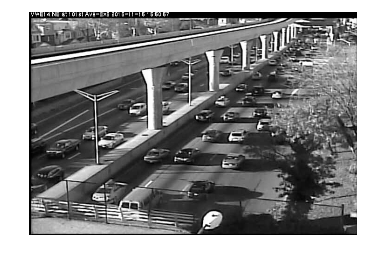

In [4]:
image_raw = ImageProcessing() 
image_raw.load_image('camera_data/1447617211_cctv589.jpg')
image_raw.plot()


Now, by visual inspection we will obtain the coordinates of the largest visible 3-lane by 2-dash portion of the road. ![](https://raw.githubusercontent.com/rmalarc/is602/master/final_project/camera_data/road_sample.jpg)

For the vantage point above, the coordinates of the mask is:

`[
    (322, 262),
    (174, 370),
    (486, 275),
    (404, 396)
]`

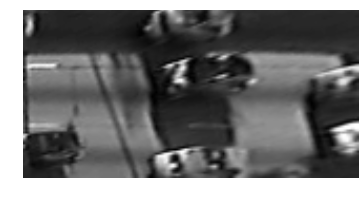

0.18105625130638292

In [5]:
dst = np.array((
    (322, 262),
    (174, 370),
    (486, 275),
    (404, 396)
))

image_raw.warp(dst)
image_raw.plot()
image_raw.image.std()

Now, let's de-noise the picture and get the standard deviation.

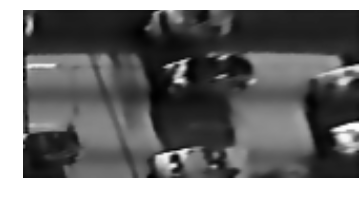

0.17575510389065285

In [6]:
image_raw.denoise(sigma_range=0.1,sigma_spatial=5)
image_raw.plot()
image_raw.image.std()

We can now threshold the image and obtain the object count. 

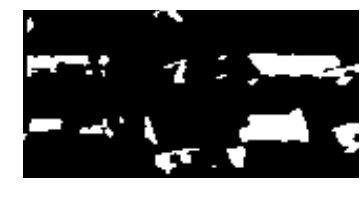

24

In [7]:
image_raw.threshold(image_raw.image.mean()*1.75)
image_raw.plot()
image_raw.object_count()

## Road Sample Masks

<table><tr>
<td>VWE @ 101 Ave NB - Cam 589<img src="https://raw.githubusercontent.com/rmalarc/is602/master/final_project/road_sample_589.jpg"></td>
<td>VWE @ 101 Ave SB - Cam 590<img src="https://raw.githubusercontent.com/rmalarc/is602/master/final_project/road_sample_590.jpg"></td>
<td>VWE @ 91 Ave - Cam 592<img src="https://raw.githubusercontent.com/rmalarc/is602/master/final_project/road_sample_592.jpg"></td></tr><tr>
<td>VWE @ Hillside Ave - Cam 593<img src="https://raw.githubusercontent.com/rmalarc/is602/master/final_project/road_sample_593.jpg"></td>
<td>VWE @ 87 Ave - Cam 594<img src="https://raw.githubusercontent.com/rmalarc/is602/master/final_project/road_sample_594.jpg"></td>
<td></td></tr></table>

In [8]:
mask_589 = np.array((
    (322, 262),
    (174, 370),
    (486, 275),
    (404, 396)
))

mask_590 = np.array((
    (356, 288),
    (218, 397),
    (474, 296),
    (400, 418)
))

mask_592 = np.array((
    (383, 233),
    (151, 332),
    (522, 249),
    (369, 374)
))

mask_593 = np.array((
    (200, 316),
    (49, 405),
    (387, 330),
    (300, 422)
))

mask_594 = np.array((
    (227, 284),
    (0, 372),
    (331, 301),
    (121, 411)
))


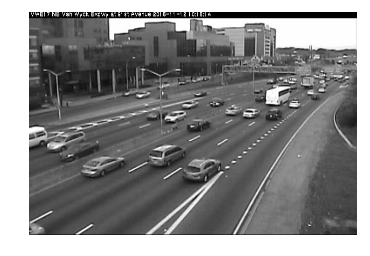

In [9]:
image_raw = ImageProcessing() 
image_raw.load_image('camera_data/1447337910_cctv592.jpg')
image_raw.plot()

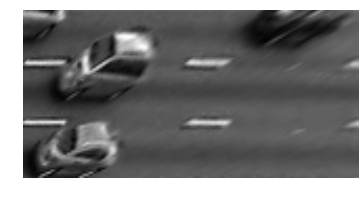

0.11529892658457679

In [10]:
image_raw.warp(mask_592)
image_raw.plot()
image_raw.image.std()

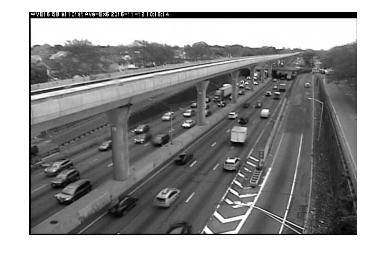

In [11]:
image_raw = ImageProcessing() 
image_raw.load_image('camera_data/1447337910_cctv590.jpg')
image_raw.plot()

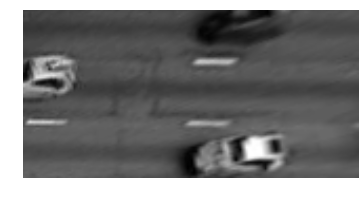

0.11065675082560367

In [12]:
image_raw.warp(mask_590)
image_raw.plot()
image_raw.image.std()

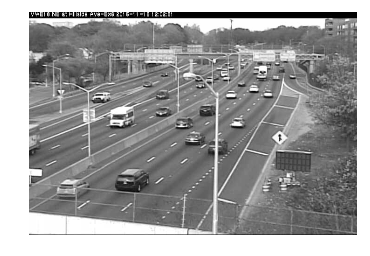

In [13]:
image_raw = ImageProcessing() 
image_raw.load_image('camera_data/1447862248_cctv593.jpg')
image_raw.plot()

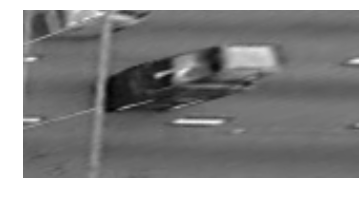

0.10465998517816674

In [14]:
image_raw.warp(mask_593)
image_raw.plot()
image_raw.image.std()

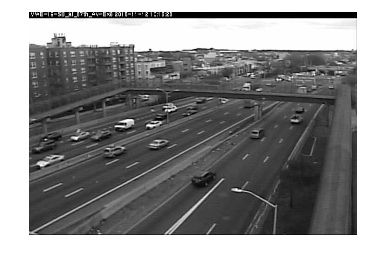

In [15]:
image_raw = ImageProcessing() 
image_raw.load_image('camera_data/1447337910_cctv594.jpg')
image_raw.plot()

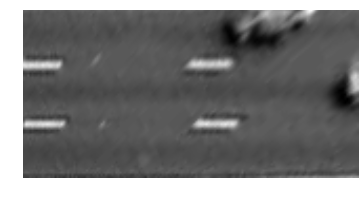

0.068335559686322322

In [16]:
image_raw.warp(mask_594)
image_raw.plot()
image_raw.image.std()

## Bulk Feature Extraction

With all the pieces in place, we can now process all the available images and extract the desired features.

Please note that outlier images have been manually removed from the collection. These outliers include:
* Out of service images: This is displayed when the camera is being serviced
* Diferent vantage point images: Some of the cameras have PTZ capabilities (pan, tilt, zoom). This allows the operator to point the camera at will. Images not consistent with the above depicted orientation have been removed.

Let's extract the features and export them as csv including the following columns:
* timestamp
* filename
* camera_id
* image_std
* image_object_ct : Object count at threshold level > mean * 0.75
* image_object_ct_l : Object count at threshold level < mean - std (The left tail)
* image_object_ct_r : Object count at threshold level > mean + std (The right tail)
* image_object_ct_lr : Object count at threshold level > mean + std OR < mean - std (the left and right tails)
* image_object_ct_c : Object count at threshold level < mean + std AND > mean - std (the center cut)

Let's code:


In [17]:

image_raw = ImageProcessing() 
base_dir = "./camera_data/"

features = []

for filename in os.listdir(base_dir):
    if '.jpg' in filename:
        camera_id = filename[-7:-4]
        timestamp = filename[:10]
        mask = eval("mask_"+camera_id)

        image_raw.load_image(base_dir+filename)
        image_raw.warp(mask)
        image_raw.denoise(sigma_range=0.1,sigma_spatial=5)

        image_std = image_raw.image.std()
        image_mean = image_raw.image.mean()

        # left tail
        image_l = image_raw.image < (image_mean-image_std)
        image_object_ct_l = label(image_l).max()+1

        # right tail
        image_r = image_raw.image > (image_mean+image_std)
        image_object_ct_r = label(image_r).max()+1

        # left_right tail
        image_lr = np.logical_or(image_l,image_r)
        image_object_ct_lr = label(image_lr).max()+1

        # center cut
        image_c = np.logical_not(image_l,image_r)
        image_object_ct_c = label(image_c).max()+1

        image_raw.threshold(image_raw.image.mean()*1.75)
        image_object_ct = image_raw.object_count()

        features.append({"timestamp":timestamp,
                         "filename":filename,
                         "camera_id":camera_id,
                         "image_std":image_std,
                         "image_object_ct":image_object_ct,
                         "image_object_ct_l":image_object_ct_l,
                         "image_object_ct_r":image_object_ct_r,
                         "image_object_ct_lr":image_object_ct_lr,
                         "image_object_ct_c":image_object_ct_c
                        })

features_df = pandas.DataFrame(features)


In [18]:
features_df.head()

,camera_id,filename,image_object_ct,image_object_ct_c,image_object_ct_l,image_object_ct_lr,image_object_ct_r,image_std,timestamp
0,589,1447258654_cctv589.jpg,7,10,10,24,17,0.086155,1447258654
1,594,1447258654_cctv594.jpg,5,12,12,13,6,0.050327,1447258654
2,589,1447260454_cctv589.jpg,11,9,9,28,17,0.084551,1447260454
3,594,1447260454_cctv594.jpg,5,20,20,17,9,0.054599,1447260454
4,594,1447262255_cctv594.jpg,5,29,29,27,7,0.054990,1447262255


In [19]:
features_df.to_csv('camera_features.csv')